# [Project 2: Implementing a Simple Convolutional Neural Network (CNN)](https://github.com/jcp-tech/Seneca_Class_Notes/blob/master/Semester%202/AIG220%20-%20Deep%20Learning/Project%202/Project_2%20S25.ipynb)

## Introduction

In this project, you will design, implement, and evaluate a simple Convolutional Neural Network (CNN) from scratch. This will involve building the entire pipeline, from data preprocessing to model training and evaluation.

## Objectives

1. Set up TensorFlow or PyTorch environments. You are free to choose your preferred DL platform.
2. Use GPU for training.
3. Create a data loader and implement data preprocessing where needed.
4. Design a Convolutional Neural Network.
5. Train and evaluate your model. Make sure to clearly show loss and accuracy values. Include visualizations too.
6. Answer assessment questions.

## Dataset

You are free to choose any dataset for this project!  (Note, however, that your work should not simply mirror models already covered in the course, nor published works of others.) Kaggle would be a good source to look for datasets. Below are some examples that we have already seen, which would be of an appropriate nature; you might tackle these (with your own approach), or choose a different dataset:
- CIFAR-10: A dataset of 60,000 32x32 color images in 10 classes with 6,000 images per class.
- Fashion-MNIST: A dataset of 70,000 28x28 grayscale images of 10 different clothing caregories.


In [162]:
# --- Imports ---
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, CSVLogger, LearningRateScheduler, Callback
from tensorflow.keras.optimizers import SGD, Adam
import shutil
from PIL import Image
from sklearn.utils import class_weight
import kagglehub
from torchvision.datasets import ImageFolder
import tensorflow.keras.applications as applications

# For GPU check
script_dir = os.getcwd()
print("GPUs available:", tf.config.list_physical_devices('GPU'))

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
def plot_classwise_samples(dataset_path, class_names, samples_per_class_per_row=6, num_rows=1):
    total_samples = samples_per_class_per_row * num_rows
    for class_name in class_names:
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.exists(class_path):
            os.makedirs(class_path, exist_ok=True)
        images = os.listdir(class_path)[:total_samples]

        # Figure width fixed to notebook width, height scales with rows
        fig, axs = plt.subplots(
            num_rows,
            samples_per_class_per_row,
            figsize=(18, 18 * num_rows / samples_per_class_per_row),
            dpi=100
        )
        fig.suptitle(f"Class: {class_name}", fontsize=16, y=1.02)

        axs = axs.flatten() if total_samples > 1 else [axs]

        for i, ax in enumerate(axs):
            if i < len(images):
                img_path = os.path.join(class_path, images[i])
                img = Image.open(img_path)
                ax.imshow(img)
                ax.axis('off')
            else:
                ax.axis('off')

        # 🔧 Zero spacing between images
        plt.subplots_adjust(wspace=0.01, hspace=0.01)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.axhline(y=0.80, color='gray', linestyle='--', label='80% Threshold')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [164]:
base_path = kagglehub.dataset_download("puneet6060/intel-image-classification") # Download latest version
print("Path to dataset files:", base_path)

Path to dataset files: /home/jetauto/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


In [165]:
train_path = f"{base_path}/seg_train/seg_train"
test_path = f"{base_path}/seg_test/seg_test"
pred_path = f"{base_path}/seg_pred/seg_pred"
class_names = sorted(os.listdir(train_path))

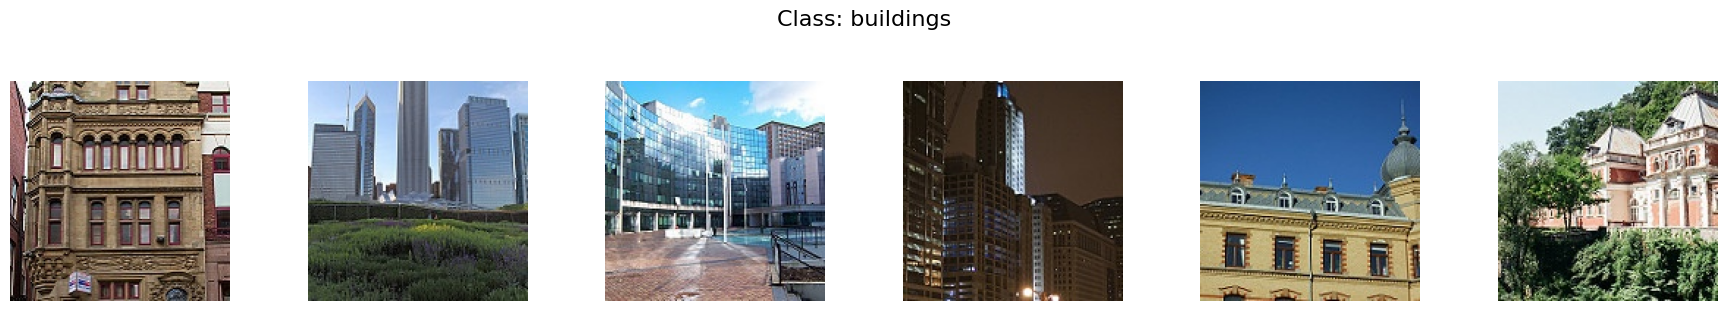

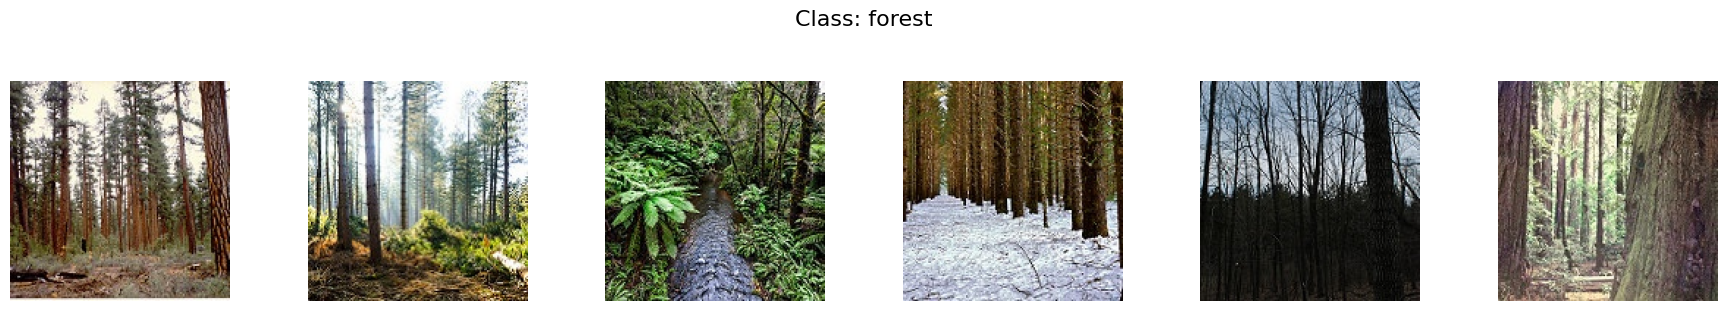

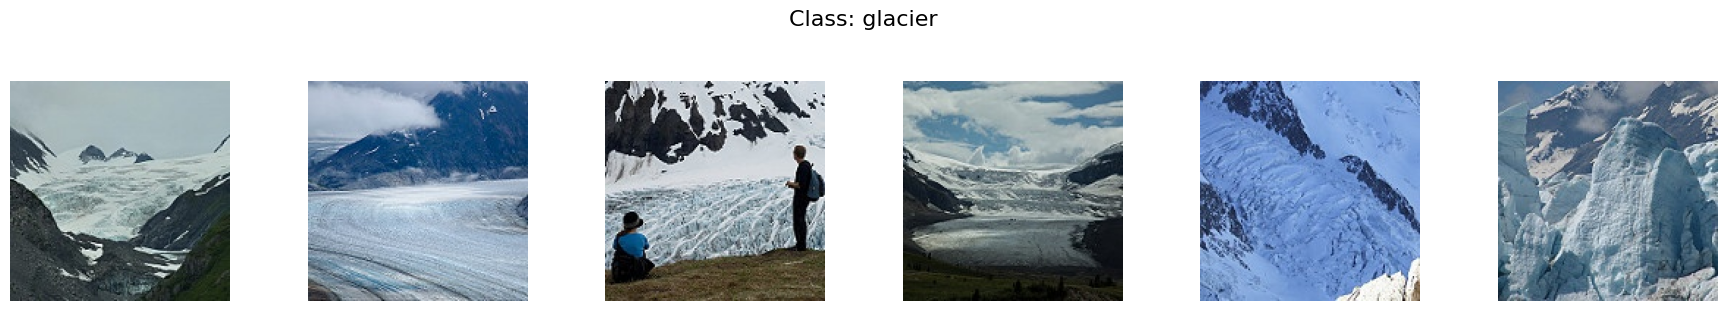

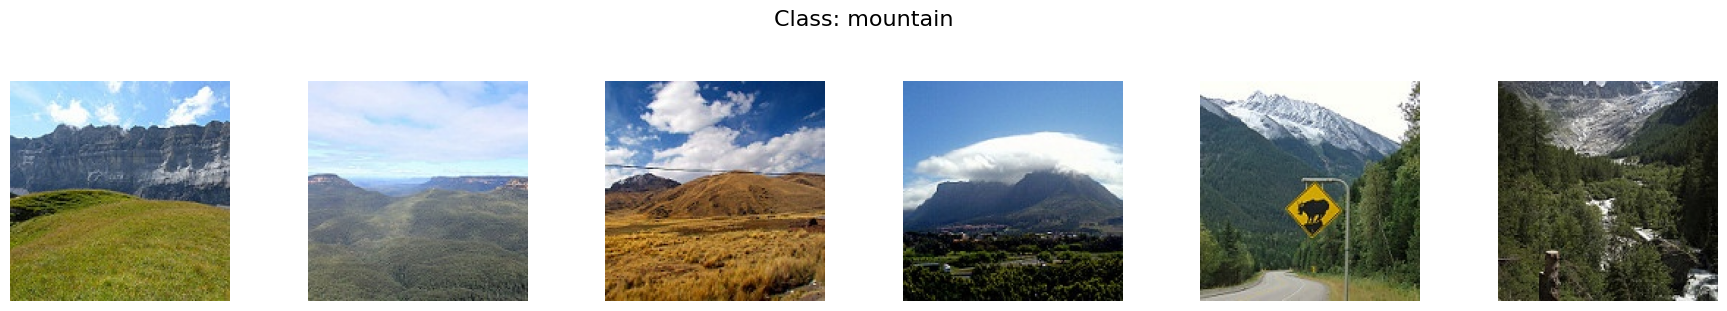

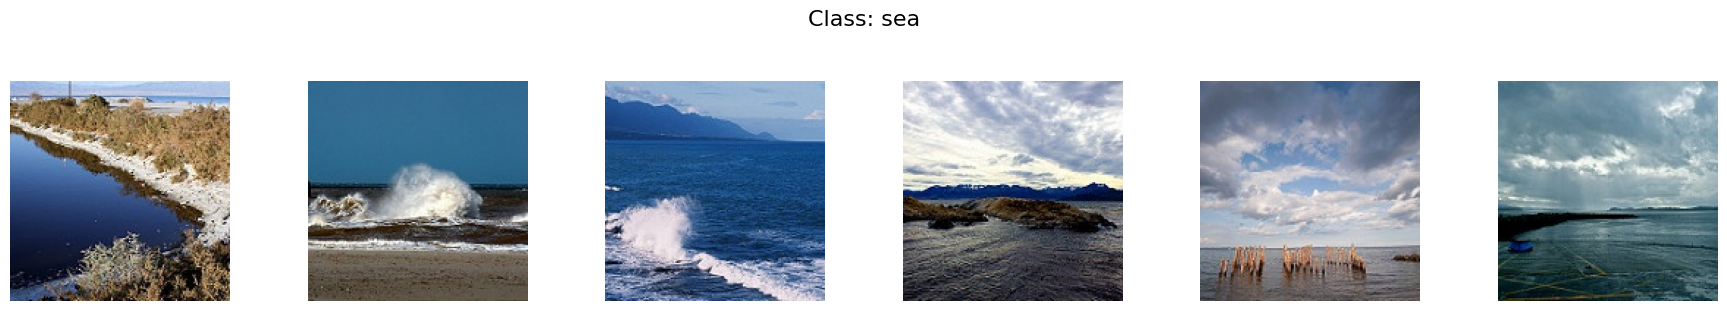

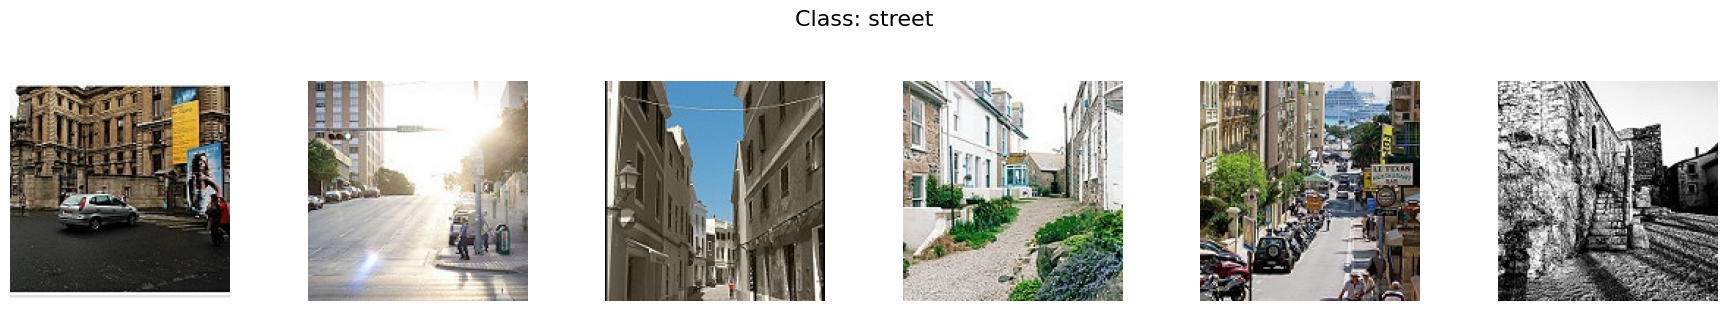

In [166]:
plot_classwise_samples(train_path, class_names) # , samples_per_class_per_row=3, num_rows=3

In [167]:
img_height = 150
img_width = 150
batch_size = 32
validation_split = 0.2
seed = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training',
    validation_split=validation_split,
    seed=seed)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation',
    validation_split=validation_split,
    seed=seed)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


In [168]:
# --- Callbacks ---
class ConditionalEarlyStopping(Callback):
    def __init__(self, monitor='val_accuracy', patience=5, threshold=0.80, mode='max'):
        super().__init__()
        self.monitor = monitor
        self.patience = patience
        self.threshold = threshold
        self.wait = 0
        self.best_weights = None
        self.best = -float('inf') if mode == 'max' else float('inf')
        self.monitor_op = (lambda a, b: a > b) if mode == 'max' else (lambda a, b: a < b)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            return

        if current >= self.threshold:
            if self.monitor_op(current, self.best):
                self.best = current
                self.wait = 0
                self.best_weights = self.model.get_weights()
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    print(f"\nEpoch {epoch+1}: early stopping (accuracy ≥ {self.threshold})")
                    self.model.stop_training = True
                    if self.best_weights is not None:
                        self.model.set_weights(self.best_weights)
    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)

early_stopping = ConditionalEarlyStopping(monitor='val_accuracy', threshold=0.80, patience=15)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

callbacks = [
    early_stopping,
    reduce_lr,
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max'),
    # TensorBoard(log_dir='logs', histogram_freq=1),
    CSVLogger('training_log.csv', append=True)
]

In [ ]:
num_classes = len(class_names)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

model = models.Sequential([
    # data_augmentation,
    
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # layers.Dropout(0.25),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 75, 75, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 37, 37, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 37, 37, 64)      

In [170]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [171]:
# Train the model
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/50
351/351 [==============================] - ETA: 0s - loss: 0.9850 - accuracy: 0.6203

/home/jetauto/Desktop/Seneca_Class_Notes/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


351/351 [==============================] - 19s 48ms/step - loss: 0.9850 - accuracy: 0.6203 - val_loss: 0.8619 - val_accuracy: 0.6885 - lr: 0.0010
Epoch 2/50
351/351 [==============================] - 5s 15ms/step - loss: 0.6294 - accuracy: 0.7714 - val_loss: 0.6391 - val_accuracy: 0.7669 - lr: 0.0010
Epoch 3/50
351/351 [==============================] - 5s 15ms/step - loss: 0.4914 - accuracy: 0.8271 - val_loss: 0.6272 - val_accuracy: 0.7716 - lr: 0.0010
Epoch 4/50
351/351 [==============================] - 5s 14ms/step - loss: 0.4054 - accuracy: 0.8560 - val_loss: 0.8603 - val_accuracy: 0.7071 - lr: 0.0010
Epoch 5/50
351/351 [==============================] - 5s 15ms/step - loss: 0.3109 - accuracy: 0.8897 - val_loss: 0.7362 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 6/50
351/351 [==============================] - 5s 14ms/step - loss: 0.2291 - accuracy: 0.9212 - val_loss: 0.9695 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 7/50
351/351 [==============================] - 5s 15ms/step - loss:

In [172]:
loss, acc = model.evaluate(test_ds)
print(f"\n✅ Final Test Accuracy (main): {acc*100:.2f}%")

94/94 [==============================] - 3s 34ms/step - loss: 1.6078 - accuracy: 0.8017

✅ Final Test Accuracy (main): 80.17%


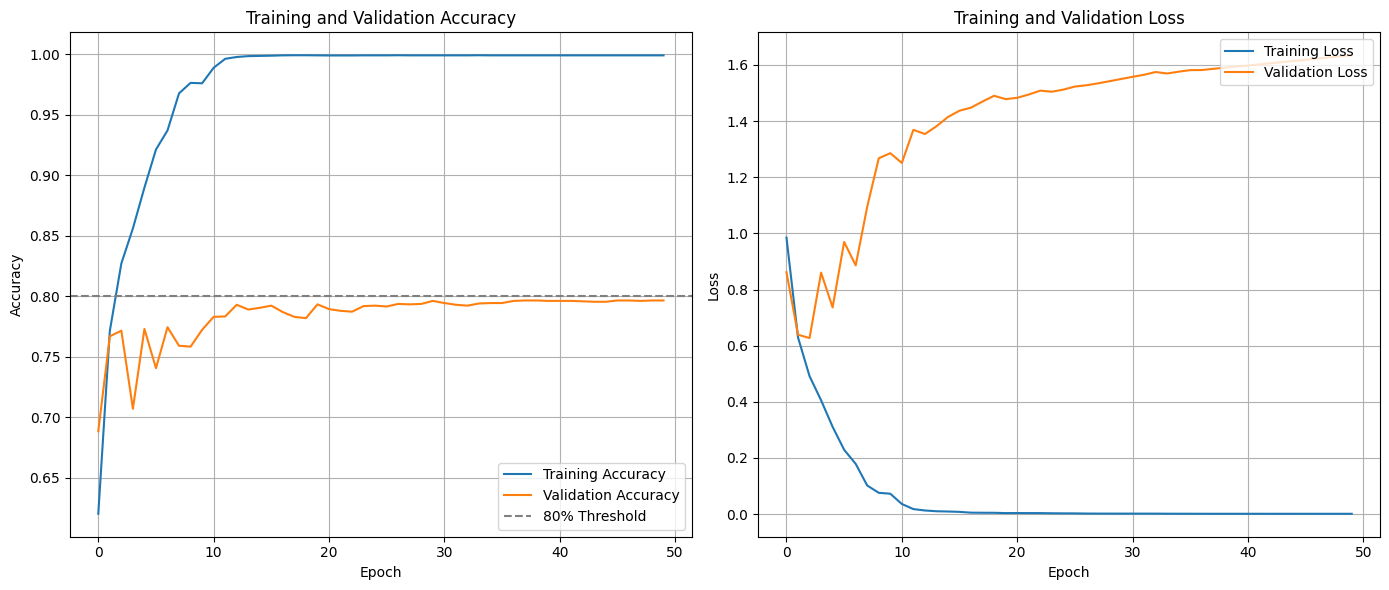

In [173]:
plot_training_history(history)

In [174]:
output_dir_main = os.path.join(script_dir, "intel_predictions", "main")
os.makedirs(output_dir_main, exist_ok=True)
# output_dir_improved = os.path.join(script_dir, "intel_predictions", "improved")
# os.makedirs(output_dir_improved, exist_ok=True)

In [ ]:
def save_predictions(model, output_dir, class_names):
    # Create subfolders for each class
    for class_name in class_names:
        class_dir = os.path.join(output_dir, class_name)
        if not os.path.exists(class_dir) or not os.listdir(class_dir):
            os.makedirs(class_dir, exist_ok=True)

    # Define transform for input images using the correct image size
    img_size = (img_height, img_width)  # Using the global img_height and img_width variables

    def preprocess_image(path):
        img = Image.open(path).convert("RGB").resize(img_size)
        img_array = np.array(img) / 255.0  # normalize
        return np.expand_dims(img_array, axis=0)  # shape: (1, 150, 150, 3)

    # Predict and move files
    for filename in os.listdir(pred_path):
        file_path = os.path.join(pred_path, filename)

        if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
            continue  # skip non-image files

        img = preprocess_image(file_path)
        pred = model.predict(img, verbose=0)
        pred_class_index = np.argmax(pred)
        pred_class = class_names[pred_class_index]

        # # Count per class
        # predicted_counts[pred_class] = predicted_counts.get(pred_class, 0) + 1

        # Move file to class-labeled folder
        dest_path = os.path.join(output_dir, pred_class, filename)
        shutil.copy(file_path, dest_path)

    print("✅ Predictions saved to:", output_dir)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f4828b832e0>>
Traceback (most recent call last):
  File "/home/jetauto/Desktop/Seneca_Class_Notes/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


✅ Predictions saved to: /home/jetauto/Desktop/Seneca_Class_Notes/Semester 2/AIG220 - Deep Learning/Project 2/intel_predictions/main


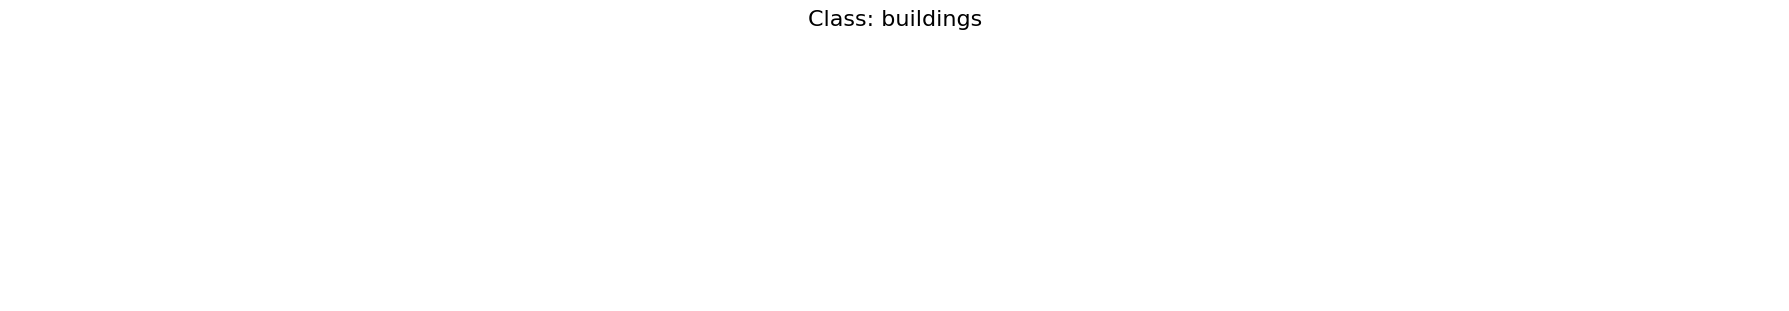

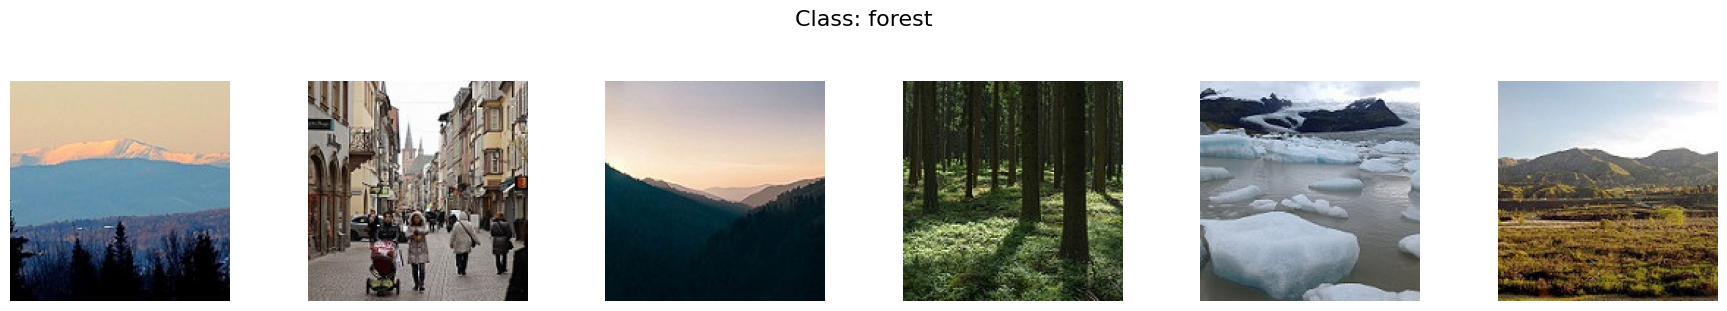

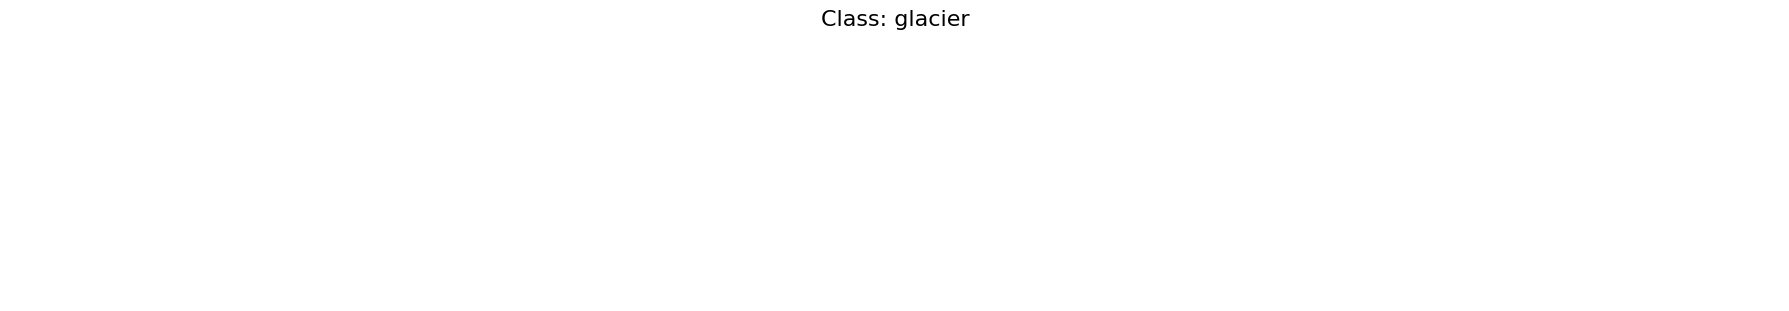

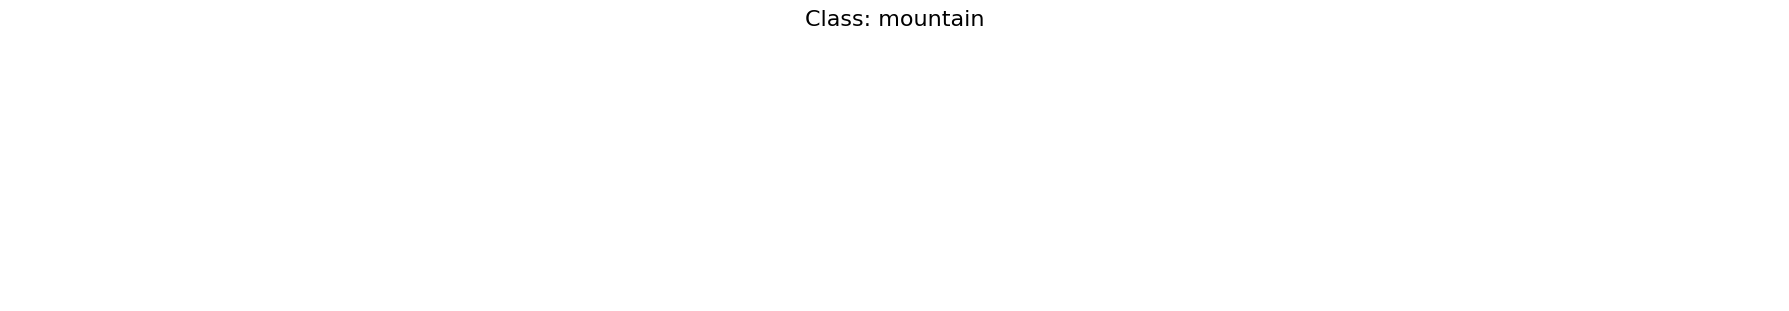

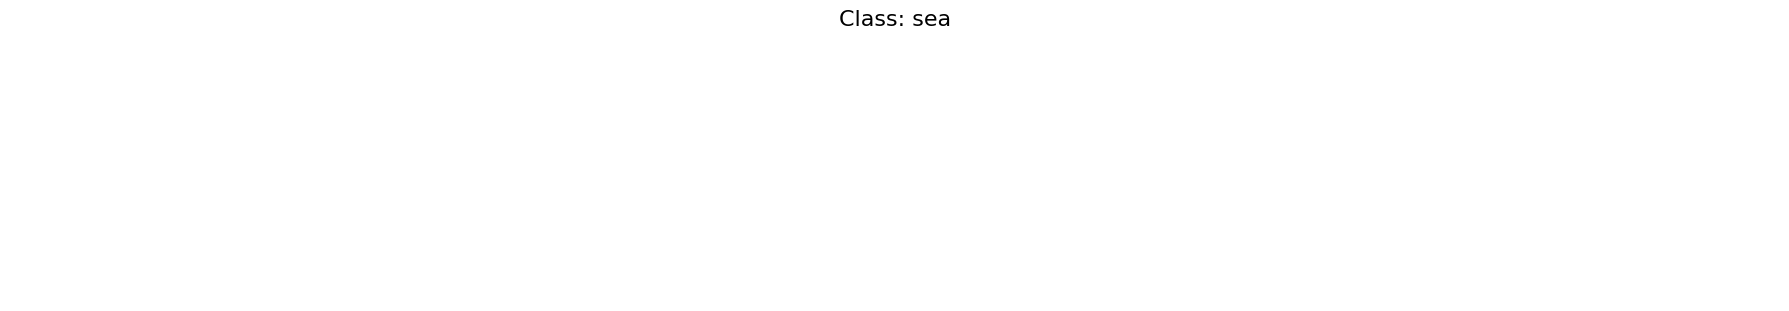

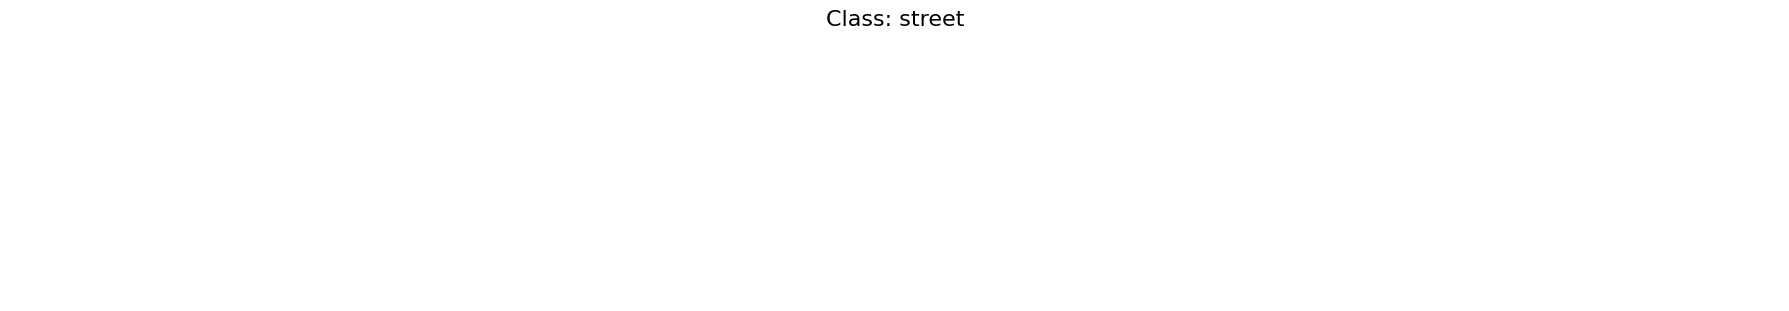

In [179]:
save_predictions(model, output_dir_main, class_names)  # Save predictions
plot_classwise_samples(output_dir_main, class_names)  # Visualize predictions

---
### Questions
Answer the following questions in detail.

1. What is a Convolutional Neural Network (CNN)? Describe its key components and how they differ from those in a fully connected neural network.
2. Explain the purpose of the convolution operation in a CNN. How does the use of different filter sizes affect the feature maps?
3. What is the purpose of a pooling layer in a CNN, and how does it contribute to the network’s performance?
4. Why are activation functions important in CNNs? Compare the use of ReLU (Rectified Linear Unit) with other activation functions.
5. Describe the process of training a CNN. What are some common challenges faced during training?
6. What are some common evaluation metrics used to assess the performance of a CNN on a classification task?
7. How does data augmentation help improve the performance of a CNN? Provide examples of common data augmentation techniques.


---
### Submission
Submit a link to your completed Jupyter Notebook (e.g., on GitHub (private) or Google Colab) with all the cells executed, and answers to the assessment questions included at the end of the notebook.